In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from IPython.display import display, Math
from astropy.io import fits

In [2]:
data = np.genfromtxt("jla_lcparams.txt", delimiter=" ", usemask=False).transpose()

In [3]:
zcmb, zhel, dz, mb, dmb, x1, dx1, color, dcolor, thirdvar, dthirdvar, tmax, dtmax, cov_m_s, cov_m_c, cov_s_c, set, ra, dec, biascor = data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9], data[10], data[11], data[12], data[13], data[14], data[15], data[16], data[17], data[18], data[19], data[20]  

In [119]:
thirdvar

array([ 9.517   ,  9.169   , 11.58    , 10.821   ,  8.647   ,  9.715   ,
        8.53    , 10.391   , 10.651   , 10.695   , 10.198   , 10.211   ,
       10.831   ,  9.339   , 10.628   ,  8.751   ,  9.464   ,  6.      ,
       11.008   ,  9.705   , 10.389   ,  9.414   ,  9.879   ,  5.294   ,
       10.005   ,  7.638   , 10.162   ,  6.      , 10.635   ,  9.64    ,
        8.73    ,  8.199   ,  9.645   ,  8.086   ,  9.034   , 10.38    ,
       11.338   ,  9.929   ,  7.966   ,  9.17    ,  9.397   , 10.418   ,
       10.215   ,  9.808   , 11.382   ,  9.314   , 10.496   ,  9.888   ,
        9.769   , 10.623   , 10.638   , 10.416   ,  9.642   ,  7.542   ,
       10.809   , 10.235   ,  8.386   , 10.246   ,  9.326   ,  8.834   ,
        6.      , 10.991   ,  6.      , 10.96    ,  9.097   ,  9.548   ,
        9.517   ,  9.98    ,  9.48    ,  6.      , 10.485   , 10.29    ,
       10.189   ,  9.299   , 11.34    ,  6.      , 10.79    ,  9.287   ,
        8.459   ,  8.895   , 11.111   ,  9.719   , 

In [9]:
def delta(a,b):
    if a==b:
        return 1
    else:
        return 0

In [11]:
hdul = fits.open('C_stat.fits')
COV = hdul[0].data

(2220, 2220)

In [13]:
C00 = np.delete(np.genfromtxt("jla_v0_covmatrix.dat", usemask=False), 0)
C11 = np.delete(np.genfromtxt("jla_va_covmatrix.dat", usemask=False), 0)
C22 = np.delete(np.genfromtxt("jla_vb_covmatrix.dat", usemask=False), 0)
C01 = np.delete(np.genfromtxt("jla_v0a_covmatrix.dat", usemask=False), 0)
C02 = np.delete(np.genfromtxt("jla_v0b_covmatrix.dat", usemask=False), 0)
C12 = np.delete(np.genfromtxt("jla_vab_covmatrix.dat", usemask=False), 0)

In [15]:
ifmass = np.array([])

for i in thirdvar:
    if i>10:
        ifmass = np.block([ifmass, 1])
    else:
        ifmass = np.block([ifmass, 0])

In [17]:
def mu_lcdm(z,Om):
    cosmo = FlatLambdaCDM(H0=70, Om0=Om)
    return 5*np.log10((cosmo.luminosity_distance(z).to_value(u.pc)/(10*u.pc)).value)

In [19]:
def mu_dat(mb, x1, color, M1b, dM1b, alpha, beta):
    return mb - (M1b + dM1b*ifmass - alpha*x1 + beta*color)

def err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c):
    return dmb*dmb + alpha*alpha*dx1*dx1 + beta*beta*dcolor*dcolor + 2*alpha*cov_m_s - 2*alpha*beta*cov_s_c - 2*beta*cov_m_c

def Amat(alpha, beta):
    iden = np.identity(740)
    Ahor = np.array([1,alpha,-beta])
    A = np.tensordot(iden, Ahor, axes = 0).reshape((740,2220))

    return A

def cov(sigma_mu, alpha, beta):
    
    cov = C00 + alpha*alpha*C11 + beta*beta*C22 + 2*alpha*C01 - 2*beta*C02 - 2*alpha*beta*C12
    cov = cov.reshape((740,740))
    cov = cov + np.diagflat(sigma_mu)

    A = A(alpha, beta)
    cov = np.matmul(A,np.matmul(cov,A.transpose()))

    return cov

In [21]:
def log_likelihood(theta, zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c):
    
    Om, alpha, beta, M1b, dM1b = theta
    
    mulcdm = mu_lcdm(zcmb, Om)
    mudat = mu_dat(mb, x1, color, M1b, dM1b, alpha, beta)
    res = mulcdm - mudat
    
    #sigma_mu = err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c)

    A = Amat(alpha, beta)
    
    incov = np.linalg.inv(np.matmul(A,np.matmul(COV,A.transpose())))

    xisq = np.matmul(res.transpose(), np.matmul(incov, res))
    
    return -0.5 * xisq

In [23]:
def log_prior(theta):
    Om, alpha, beta, M1b, dM1b = theta
    if 0.2 < Om < 0.6 and 0 < alpha < 0.3 and 1 < beta < 4 and -25 < M1b < -17 and -0.5 < dM1b < 0.0:
        return 0.0
    return -np.inf

In [25]:
def log_probability(theta, zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c)

In [27]:
def mcmc(p,nwalkers,niter,ndim,nburn,log_probability,zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c))

    print("Running burn-in...")
    p, _, _ = sampler.run_mcmc(p, nburn, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p, niter, progress=True)

    return sampler, pos, prob, state

In [103]:
nwalkers = 20
niter = 200
nburn = 200

initial = [0.3, 0.2, 2, -20, -0.1]

ndim = len(initial)
p0 = [np.array(initial) + 1e-2* np.random.randn(ndim) for i in range(nwalkers)]

In [105]:
sampler, pos, prob, state = mcmc(p0,nwalkers,niter,ndim,nburn,log_probability,zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c)

Running burn-in...


100%|██████████████████████████████████████| 200/200 [7:53:36<00:00, 142.08s/it]


Running production...


100%|█████████████████████████████████████████| 200/200 [15:30<00:00,  4.65s/it]


In [106]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([  0.32557149,   0.15963934,   3.02971725, -19.01174484,
        -0.13260753])

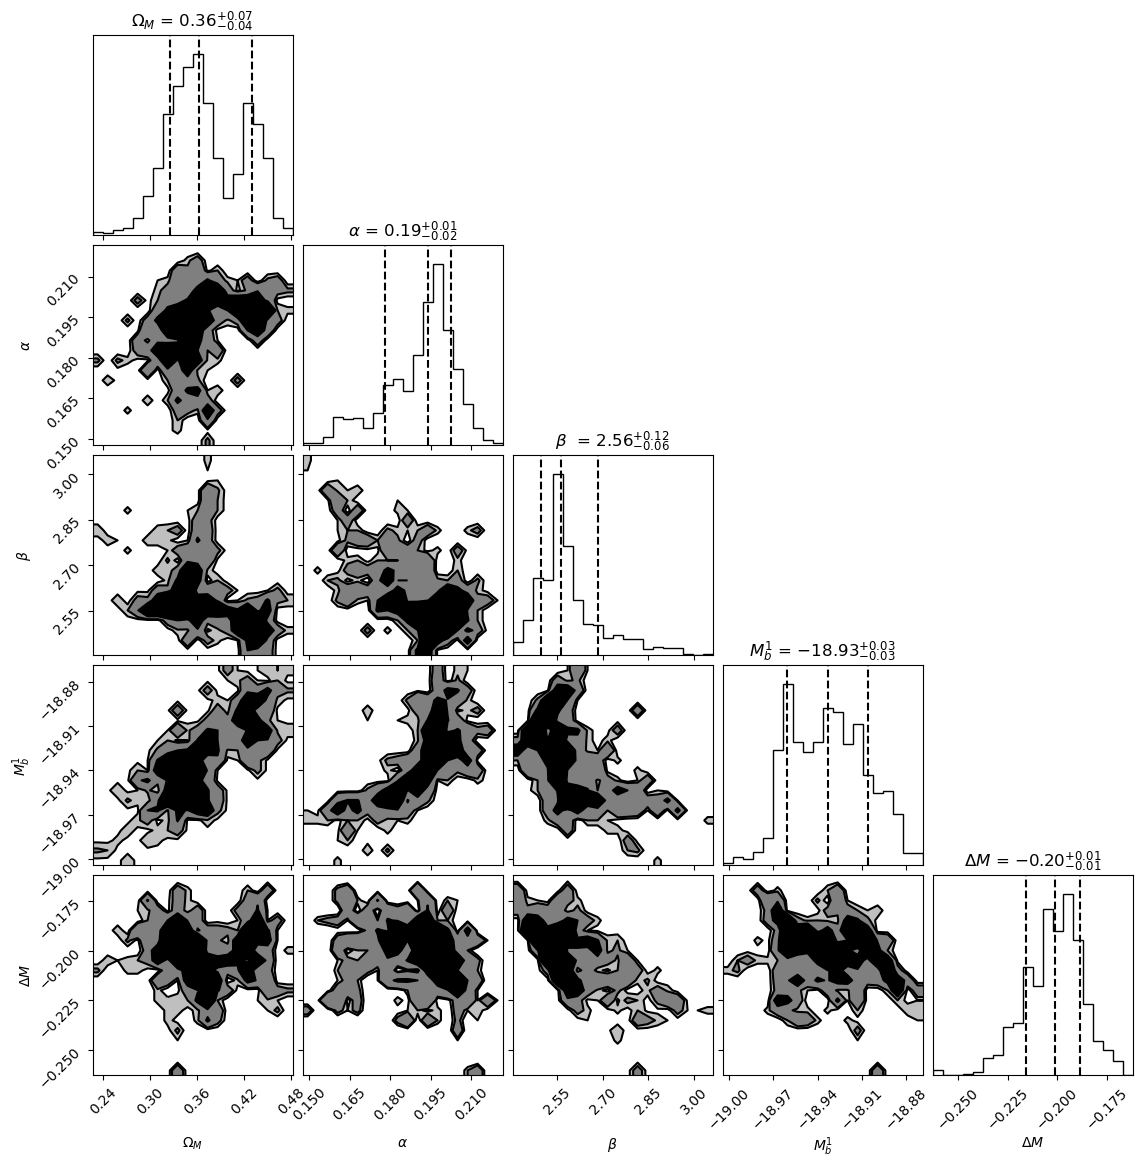

In [113]:
labels = ['$\\Omega_M$', '$\\alpha$', '$\\beta$ ', '$M^1_b$', '$\\Delta M$']
fig = corner.corner(samples[:2000],show_titles=True,labels=labels,plot_datapoints=False,levels=(0.68,0.95,0.99),fill_contours=True,plot_density=False,quantiles=[0.16, 0.5, 0.84])

In [115]:
Om, alpha, beta, M1b, dM1b = 0.23, 0.15, 3, -20, -0.07
    
mulcdm = mu_lcdm(zcmb, Om)
mudat = mu_dat(mb, x1, color, M1b, dM1b, alpha, beta)
res = mulcdm - mudat
    
    #sigma_mu = err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c)

A = Amat(alpha, beta)
    
incov = np.linalg.inv(np.matmul(A,np.matmul(COV,A.transpose())))

xisq = np.matmul(res.transpose(), np.matmul(incov, res))
-0.5 * xisq

-20019.472131989336

In [127]:
samplespru = np.genfromtxt("adj_samples_1000-800-200_err1.txt")

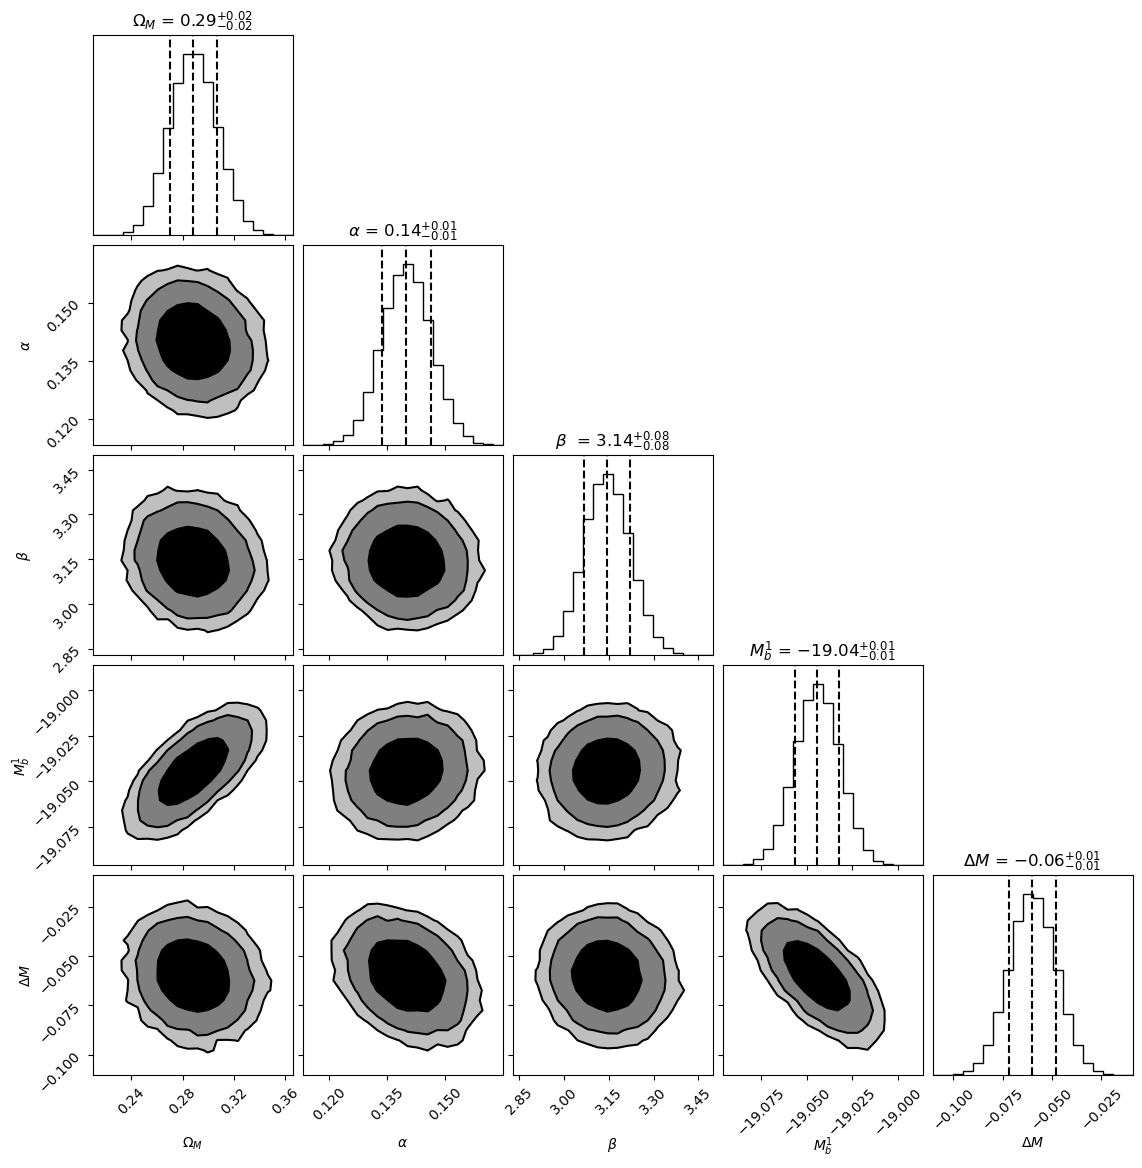

In [145]:
labels = ['$\\Omega_M$', '$\\alpha$', '$\\beta$ ', '$M^1_b$', '$\\Delta M$']
fig = corner.corner(samplespru[1:],show_titles=True,labels=labels,plot_datapoints=False,levels=(0.68,0.95,0.99),fill_contours=True,plot_density=False,quantiles=[0.16, 0.5, 0.84])